In [11]:
import h5py
import itertools
import glob
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time

from networkx.algorithms import community
from neuropacks import PVC11, NHP, ECOG
from sklearn.neighbors import KernelDensity
from uoineuro.utils import obtain_tuning_preferences
from uoineuro.tuning_utils import calculate_best_frequencies_ecog
from uoineuro.coupling_utils import *

%matplotlib inline

In [2]:
base_path = os.path.join(os.environ['HOME'], 'fits/uoineuro/coupling')

In [3]:
# consolidate AC results
ac_results_path = os.path.join(base_path, 'ecog/ecog_coupling.h5')
ac_results = h5py.File(ac_results_path, 'r')
ac_lasso_ccs = np.median(ac_results['lasso/coupling_coefs'], axis=0)
ac_uoi_lasso_ccs = np.median(ac_results['uoi_lasso_bic/coupling_coefs'], axis=0)

In [4]:
# consolidate VC results
vc_results_paths = [os.path.join(base_path, 'pvc11/pvc11_monkey1_coupling.h5'),
                    os.path.join(base_path, 'pvc11/pvc11_monkey2_coupling.h5'),
                    os.path.join(base_path, 'pvc11/pvc11_monkey3_coupling.h5')]
n_vc_fits = len(vc_results_paths)
vc_results = [h5py.File(vc_results_path, 'r')
              for vc_results_path in vc_results_paths]
# extract coupling coefficients
vc_lasso_ccs = [np.median(vc_result['lasso/coupling_coefs'], axis=0)
                for vc_result in vc_results]
vc_uoi_lasso_ccs = [np.median(vc_result['uoi_lasso_bic/coupling_coefs'], axis=0)
              for vc_result in vc_results]
vc_glmnet_ccs = [np.median(vc_result['glmnet_poisson/coupling_coefs'], axis=0)
                for vc_result in vc_results]
vc_uoi_poisson_ccs = [np.median(vc_result['uoi_poisson_bic/coupling_coefs'], axis=0)
              for vc_result in vc_results]

In [5]:
# consolidate MC results
mc_results_paths = [os.path.join(base_path, 'nhp/nhp_indy_20160407_02_coupling.h5'),
                    os.path.join(base_path, 'nhp/nhp_indy_20160411_01_coupling.h5'),
                    os.path.join(base_path, 'nhp/nhp_indy_20160411_02_coupling.h5')]
n_mc_fits = len(mc_results_paths)
mc_results = [h5py.File(mc_results_path, 'r')
              for mc_results_path in mc_results_paths]
# extract coupling coefficients
mc_lasso_ccs = [np.median(mc_result['lasso/coupling_coefs'], axis=0)
                for mc_result in mc_results]
mc_uoi_lasso_ccs = [np.median(mc_result['uoi_lasso_bic/coupling_coefs'], axis=0)
              for mc_result in mc_results]
mc_glmnet_ccs = [np.median(mc_result['glmnet_poisson/coupling_coefs'], axis=0)
                for mc_result in mc_results]
mc_uoi_poisson_ccs = [np.median(mc_result['uoi_poisson_bic/coupling_coefs'], axis=0)
              for mc_result in mc_results]

In [6]:
lasso_ccs = [ac_lasso_ccs] + vc_lasso_ccs + mc_lasso_ccs
uoi_lasso_ccs = [ac_uoi_lasso_ccs] + vc_uoi_lasso_ccs + mc_uoi_lasso_ccs
glmnet_ccs = vc_glmnet_ccs + mc_glmnet_ccs
uoi_poisson_ccs = vc_uoi_poisson_ccs + mc_uoi_poisson_ccs

In [7]:
lasso_sgraphs = [create_symmetrized_graph(lasso_ccs[idx])[0]
                for idx in range(len(lasso_ccs))]
uoi_lasso_sgraphs = [create_symmetrized_graph(uoi_lasso_ccs[idx])[0]
                    for idx in range(len(uoi_lasso_ccs))]
glmnet_sgraphs = [create_symmetrized_graph(glmnet_ccs[idx])[0]
                 for idx in range(len(glmnet_ccs))]
uoi_poisson_sgraphs = [create_symmetrized_graph(uoi_poisson_ccs[idx])[0]
                      for idx in range(len(uoi_poisson_ccs))]

In [8]:
lasso_dgraphs = [create_directed_graph(lasso_ccs[idx], weighted=True)
                for idx in range(len(lasso_ccs))]
uoi_lasso_dgraphs = [create_directed_graph(uoi_lasso_ccs[idx], weighted=True)
                    for idx in range(len(uoi_lasso_ccs))]
glmnet_dgraphs = [create_directed_graph(glmnet_ccs[idx], weighted=True)
                 for idx in range(len(glmnet_ccs))]
uoi_poisson_dgraphs = [create_directed_graph(uoi_poisson_ccs[idx], weighted=True)
                      for idx in range(len(uoi_poisson_ccs))]

In [9]:
d_graphs = {
    'ac_baseline': lasso_dgraphs[0],
    'ac_uoi': uoi_lasso_dgraphs[0],
    'vc_monkey1_baseline': glmnet_dgraphs[0],
    'vc_monkey2_baseline': glmnet_dgraphs[1],
    'vc_monkey3_baseline': glmnet_dgraphs[2],
    'mc_monkey1_baseline': glmnet_dgraphs[3],
    'mc_monkey2_baseline': glmnet_dgraphs[4],
    'mc_monkey3_baseline': glmnet_dgraphs[5],
    'vc_monkey1_uoi': uoi_poisson_dgraphs[0],
    'vc_monkey2_uoi': uoi_poisson_dgraphs[1],
    'vc_monkey3_uoi': uoi_poisson_dgraphs[2],
    'mc_monkey1_uoi': uoi_poisson_dgraphs[3],
    'mc_monkey2_uoi': uoi_poisson_dgraphs[4],
    'mc_monkey3_uoi': uoi_poisson_dgraphs[5],
}

In [10]:
s_graphs = {
    'ac_baseline': lasso_sgraphs[0],
    'ac_uoi': uoi_lasso_sgraphs[0],
    'vc_monkey1_baseline': glmnet_sgraphs[0],
    'vc_monkey2_baseline': glmnet_sgraphs[1],
    'vc_monkey3_baseline': glmnet_sgraphs[2],
    'mc_monkey1_baseline': glmnet_sgraphs[3],
    'mc_monkey2_baseline': glmnet_sgraphs[4],
    'mc_monkey3_baseline': glmnet_sgraphs[5],
    'vc_monkey1_uoi': uoi_poisson_sgraphs[0],
    'vc_monkey2_uoi': uoi_poisson_sgraphs[1],
    'vc_monkey3_uoi': uoi_poisson_sgraphs[2],
    'mc_monkey1_uoi': uoi_poisson_sgraphs[3],
    'mc_monkey2_uoi': uoi_poisson_sgraphs[4],
    'mc_monkey3_uoi': uoi_poisson_sgraphs[5],
}

## In-degree / out-degree

In [66]:
in_degrees = {
    key: np.array(list(dict(val.in_degree()).values()))
    for key, val in d_graphs.items()
}

out_degrees = {
    key: np.array(list(dict(val.out_degree()).values()))
    for key, val in d_graphs.items()
}

for degrees in [in_degrees, out_degrees]:
    degrees['vc_baseline'] = np.concatenate(
        (degrees['vc_monkey1_baseline'],
         degrees['vc_monkey2_baseline'],
         degrees['vc_monkey3_baseline'])
    )
    degrees['vc_uoi'] = np.concatenate(
        (degrees['vc_monkey1_uoi'],
         degrees['vc_monkey2_uoi'],
         degrees['vc_monkey3_uoi'])
    )
    degrees['mc_baseline'] = np.concatenate(
        (degrees['mc_monkey1_baseline'],
         degrees['mc_monkey2_baseline'],
         degrees['mc_monkey3_baseline'])
    )
    degrees['mc_uoi'] = np.concatenate(
        (degrees['mc_monkey1_uoi'],
         degrees['mc_monkey2_uoi'],
         degrees['mc_monkey3_uoi'])
    )

In [165]:
in_degree_densities = {}
out_degree_densities = {}

bandwidths = [4.0, 5.0, 8.0]
baselines = ['ac_baseline', 'vc_baseline', 'mc_baseline']
uois = ['ac_uoi', 'vc_uoi', 'mc_uoi']

for bandwidth, baseline, uoi in zip(bandwidths, baselines, uois):
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(in_degrees[baseline].reshape(-1, 1))
    in_degree_densities[baseline] = kde

    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(in_degrees[uoi].reshape(-1, 1))
    in_degree_densities[uoi] = kde

    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(out_degrees[baseline].reshape(-1, 1))
    out_degree_densities[baseline] = kde

    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(in_degrees[uoi].reshape(-1, 1))
    out_degree_densities[uoi] = kde

## Modularity

In [45]:
modularities = {
    key: compute_modularity(val)
    for key, val in d_graphs.items()
}

## Small-worldness

In [13]:
small_world_omega = {}
small_world_sigma = {}

In [19]:
t = time.time()
small_world_omega['mc_monkey1_uoi'] = compute_small_worldness(
    G=s_graphs['mc_monkey1_uoi'],
    metric='omega',
    niter=50,
    nrand=2,
    seed=2332
)
print(time.time() - t)
t = time.time()
G = s_graphs['mc_monkey1_baseline']
G = max(nx.connected_component_subgraphs(G), key=len)
small_world_omega['mc_monkey1_baseline'] = nx.algorithms.smallworld.omega(G, niter=50, nrand=2, seed=2332)


{}

In [ ]:
for key, graph in s_graphs.items():
    G = graph.copy()
    G = max(nx.connected_component_subgraphs(G), key=len)
    t = time.time()
    small_world_omega[key] = nx.algorithms.smallworld.omega(G, nrand=5, seed=2332)
    print(key, ' omega: ', time.time() - t)
    
    small_world_sigma[key] = nx.algorithms.smallworld.sigma(G, nrand=5, seed=2332)
    print(key, ' sigma: ', time.time() - t)

## Tuning Preferences

In [12]:
pvc_base_path = os.path.join(os.environ['HOME'],
                         'data/pvc11/data/spikes_gratings')
pvc_monkey_paths = sorted(glob.glob(os.path.join(base_path, '*.mat')))

In [14]:
pvcs = [PVC11(data_path=monkey_path)
        for monkey_path in monkey_paths]
pvc_prefs = [obtain_tuning_preferences(pvc, 'pvc11')
             for pvc in pvcs]

In [15]:
pvc_diffs = [np.abs(np.subtract.outer(pvc_pref, pvc_pref))
             for pvc_pref in pvc_prefs]

In [68]:
pvc_As = [nx.adjacency_matrix(s_graphs['vc_monkey1_baseline']),
          nx.adjacency_matrix(s_graphs['vc_monkey2_baseline']),
          nx.adjacency_matrix(s_graphs['vc_monkey3_baseline'])]
pvc_As = [np.array(pvc_A.todense()) for pvc_A in pvc_As]

[[ 1.         -0.14683193]
 [-0.14683193  1.        ]]
[[ 1.         -0.06788401]
 [-0.06788401  1.        ]]
[[ 1.         -0.13426531]
 [-0.13426531  1.        ]]
[[ 1.         -0.05824703]
 [-0.05824703  1.        ]]
[[ 1.         -0.15386935]
 [-0.15386935  1.        ]]
[[ 1.         -0.02264153]
 [-0.02264153  1.        ]]


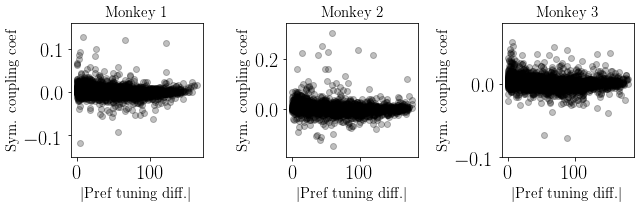

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for idx, ax in enumerate(axes):
    tridx = np.tril_indices(pvc_diffs[idx].shape[0], -1)
    ax.scatter(
        pvc_diffs[idx][tridx],
        pvc_As[idx][tridx],
        color='k',
        alpha=0.25
    )
    print(np.corrcoef(pvc_diffs[idx][tridx], pvc_As[idx][tridx]))
    print(np.corrcoef(pvc_diffs[idx][tridx], np.abs(pvc_As[idx][tridx])))
    ax.set_xlabel('$|$Pref tuning diff.$|$', fontsize=15)
    ax.set_ylabel('Sym. coupling coef', fontsize=15)
    ax.set_title(r'Monkey %s' %(idx+1), fontsize=15)
plt.tight_layout()
# plt.savefig('pvc_diff.pdf')

In [45]:
ecog_fits_path = os.path.join(os.environ['HOME'],
                         'fits/uoineuro/tuning/ecog/ecog_tuning.h5')
ecog_data_path = os.path.join(os.environ['HOME'], 'data/ecog/r32_b7.mat')
ecog_grid_path = os.path.join(os.environ['HOME'], 'data/ecog/grdid.mat')
ecog = ECOG(data_path=ecog_data_path, grid_path=ecog_grid_path)
ecog_fits = h5py.File(ecog_fits_path, 'r')

In [48]:
ecog_uoi_coefs = np.mean(ecog_fits['uoi_lasso_bic/tuning_coefs'], axis=0)
ecog_diffs = np.zeros((128, 128))

In [50]:
for e1, e2 in itertools.combinations(np.arange(128), 2):
    v1, v2 = ecog_uoi_coefs[e1], ecog_uoi_coefs[e2]
    cd = np.dot(v1, v2) / np.sqrt(np.sum(v1**2) * np.sum(v2**2))
    ecog_diffs[e1, e2] = cd
    ecog_diffs[e2, e1] = cd

In [51]:
ecog_diffs = np.nan_to_num(ecog_diffs)

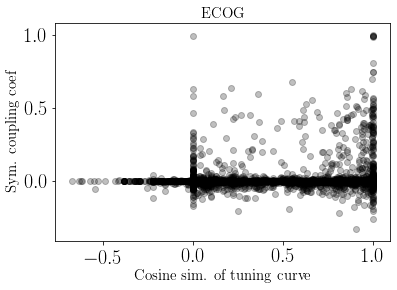

In [66]:
fig, ax = plt.subplots(1, 1)
ecog_A = np.array(nx.adjacency_matrix(s_graphs['ac_baseline']).todense())
idxs = np.tril_indices(ecog_diffs.shape[0], -1)
nz_idxs = np.argwhere(ecog_A[idxs] != 0).ravel()

ax.scatter(
    ecog_diffs[idxs],
    ecog_A[idxs],
    color='k',
    alpha=0.25
)
ax.set_xlabel('Cosine sim. of tuning curve', fontsize=15)
ax.set_ylabel('Sym. coupling coef', fontsize=15)
ax.set_title(r'ECOG', fontsize=15)
plt.savefig('ecog.pdf', bbox_inches='tight')

In [61]:
np.corrcoef(
    ecog_diffs[idxs][nz_idxs],
    ecog_A[idxs][nz_idxs])

array([[1.        , 0.22658386],
       [0.22658386, 1.        ]])

In [76]:
np.corrcoef(
    np.abs(A[idxs]),
    cosine_diffs[idxs]
)

array([[ 1., nan],
       [nan, nan]])

## Figure Plot

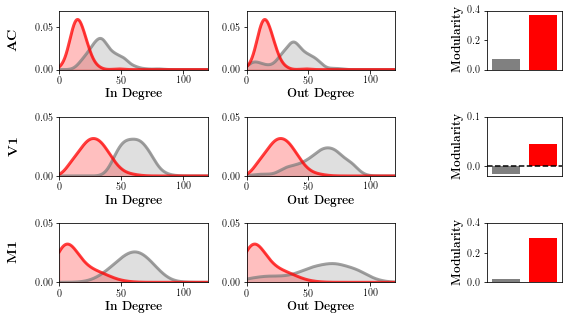

In [190]:
fig, axes = plt.subplots(3, 4, figsize=(9, 5),
                         gridspec_kw={'width_ratios': [1, 1, 0.1, 0.5]})

bins = np.linspace(0, 100, 20)
x_samples = np.linspace(0, 120, 1000)[..., np.newaxis]
colors = ['gray','red']
datasets = ['ac', 'vc', 'mc']

for idx, dataset in enumerate(datasets):
    in_ax = axes[idx, 0]
    out_ax = axes[idx, 1]
    baseline_key = dataset + '_baseline'
    uoi_key = dataset + '_uoi'
    
    for ax, degree_density in zip([in_ax, out_ax], [in_degree_densities, out_degree_densities]):
        for key, color in zip([baseline_key, uoi_key], colors):
            ax.plot(
                x_samples,
                np.exp(degree_density[key].score_samples(x_samples)),
                color=color,
                alpha=0.75,
                linewidth=3)
            ax.fill_between(
                x_samples.ravel(),
                np.exp(degree_density[key].score_samples(x_samples)),
                color=color,
                alpha=0.25)

for ax in axes[:, :2].ravel():
    ax.tick_params(labelsize=10)
    ax.set_xlim([0, 120])
    ax.set_ylim([0, 0.05])
    ax.set_yticks([0, 0.05])
    
axes[0, 0].set_ylim([0, 0.07])
axes[0, 1].set_ylim([0, 0.07])
    
# modularities
axes[0, 3].bar(x=[0, 1],
               height=[modularities['ac_baseline'], modularities['ac_uoi']],
               color=['gray', 'red'],
               width=0.75)

axes[1, 3].bar(x=[0, 1],
               height=[np.mean([modularities['vc_monkey1_baseline'],
                                modularities['vc_monkey2_baseline'],
                                modularities['vc_monkey3_baseline']]),
                       np.mean([modularities['vc_monkey1_uoi'],
                                modularities['vc_monkey2_uoi'],
                                modularities['vc_monkey3_uoi']])],
               color=['gray', 'red'],
               width=0.75)
axes[2, 3].bar(x=[0, 1],
               height=[np.mean([modularities['mc_monkey1_baseline'],
                                modularities['mc_monkey2_baseline'],
                                modularities['mc_monkey3_baseline']]),
                       np.mean([modularities['mc_monkey1_uoi'],
                                modularities['mc_monkey2_uoi'],
                                modularities['mc_monkey3_uoi']])],
               color=['gray', 'red'],
               width=0.75)

axes[1, 3].axhline(0, color='k', linestyle='--')

for ax in axes[:, 3]:
    ax.set_xlim([-0.5, 1.5])
    ax.tick_params(labelsize=10)
    ax.set_xticks([])

axes[0, 3].set_yticks([0, 0.2, 0.4])
axes[1, 3].set_yticks([0, 0.1])
axes[2, 3].set_yticks([0, 0.2, 0.4])

for ax in axes[:, 0]:
    ax.set_xlabel(r'\textbf{In Degree}', fontsize=12)
    
for ax in axes[:, 1]:
    ax.set_xlabel(r'\textbf{Out Degree}', fontsize=12)

for ax in axes[:, 3]:
    ax.set_ylabel(r'\textbf{Modularity}', fontsize=12)
    
for ax in axes[:, 2]:
    ax.axis('off')

axes[0, 0].set_ylabel(r'\textbf{AC}', fontsize=14, labelpad=15)
axes[1, 0].set_ylabel(r'\textbf{V1}', fontsize=14, labelpad=15)
axes[2, 0].set_ylabel(r'\textbf{M1}', fontsize=14, labelpad=15)

plt.subplots_adjust(hspace=0.80, wspace=0.4)
plt.savefig('graph_analysis.pdf', bbox_inches='tight')

## Controllability

In [338]:
A = nx.adjacency_matrix(create_symmetrized_graph(coupling_coefs=vc_lasso_ccs[1])[0]).todense()
B = np.zeros((A.shape[0], A.shape[0]))
# B = np.identity(A.shape[0])
B[0, 0] = 1

W = np.zeros(A.shape)
T = 500
Apow2 = np.zeros(A.shape)

for ii in range(T):
    Apow2 += np.linalg.matrix_power(A, 2*ii)
    
for ii in range(T):
    Apow = np.linalg.matrix_power(A, ii)
    W += Apow @ B @ Apow

In [328]:
G1 = create_symmetrized_graph(coupling_coefs=mc_lasso_ccs[1])[0]
G2 = create_symmetrized_graph(coupling_coefs=mc_uoi_lasso_ccs[1])[0]

A1 = nx.adjacency_matrix(G1).todense()
A2 = nx.adjacency_matrix(G2).todense()

u1, v1 = np.linalg.eigh(A1)
u2, v2 = np.linalg.eigh(A2)

mc1 = np.sum((1 - u1**2)[np.newaxis] * np.array(v1)**2, axis=1)
mc2 = np.sum(((1 - u2**2)[np.newaxis] * np.array(v2).T**2), axis=1)

dd1 = np.array([d for n,d in G1.degree()])
dd2 = np.array([d for n,d in G2.degree()])

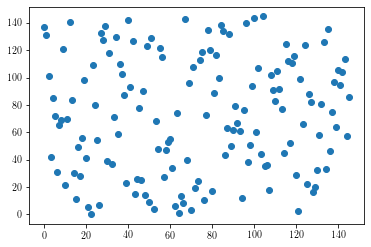

In [332]:
plt.scatter(np.argsort(dd2), np.argsort(mc2))

In [277]:
lam, v = np.linalg.eigh(A)
np.sum((1 - lam**2) * v**2, axis=1)

matrix([[-3.86898166]])

In [59]:
controllability = np.zeros((7, 2, 4, 25))

for idx, (baseline, uoi) in enumerate(zip(lasso_ccs, uoi_lasso_ccs)):
    control_baseline = compute_controllability_curves(
        create_symmetrized_graph(coupling_coefs=baseline)[0]
    )
    control_uoi = compute_controllability_curves(
        create_symmetrized_graph(coupling_coefs=uoi)[0],
    )
    controllability[idx, 0] = control_baseline.T
    controllability[idx, 1] = control_uoi.T

/home/psachdeva/anaconda3/envs/neuro/lib/python3.7/site-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/psachdeva/anaconda3/envs/neuro/lib/python3.7/site-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/psachdeva/anaconda3/envs/neuro/lib/python3.7/site-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
